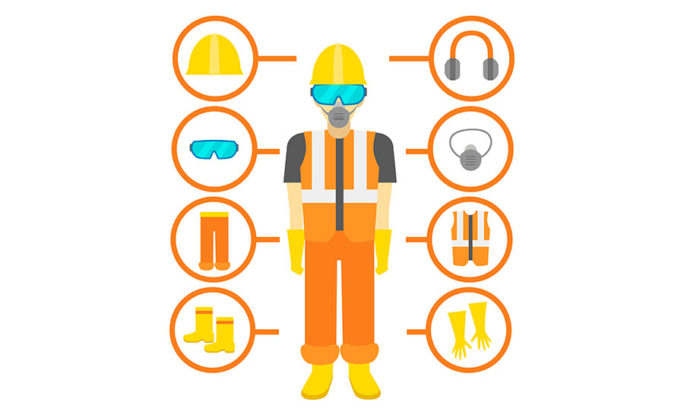

Data source: https://www.kaggle.com/datasets/khananikrahman/is-an-employee-wearing-safety-gear

# Part 1 

### Data loading and preprocessing

In [1]:
# Import necessary packages
from os import listdir , mkdir
from shutil import rmtree , copyfile
from random import sample , seed
from numpy import expand_dims
from skimage.io import imread_collection , imshow_collection , imread , imshow
from matplotlib.pyplot import show , title , plot , xlabel ,ylabel , legend
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten , Dense
from tensorflow.keras.models import Model

# Instance from 'ImageDataGenerator' object
gen = ImageDataGenerator(rescale=1/255)

In [2]:
print('There are two classes in the main directory.')
print(f'"Not Wearing Safety Gear" class containing {len(listdir("GearedorNot\\Not Wearing Safety Gear"))} samples.')
print(f'"Wearing Safety Gear" class containing {len(listdir("GearedorNot\\Wearing Safety Gear"))} samples.')

There are two classes in the main directory.
"Not Wearing Safety Gear" class containing 195 samples.
"Wearing Safety Gear" class containing 161 samples.


6 random images from "Not Wearing Safety Gear" class


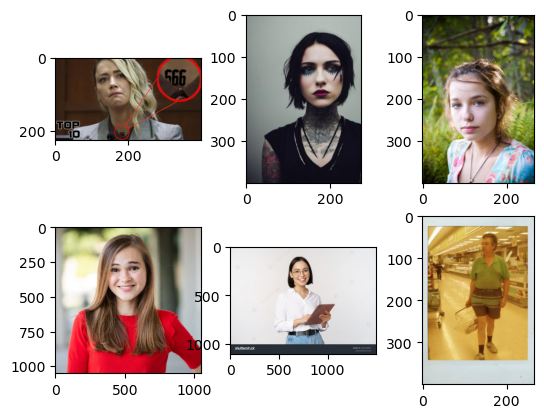

----------------------------------------------------------------------------------------------------
6 random images from "Wearing Safety Gear" class


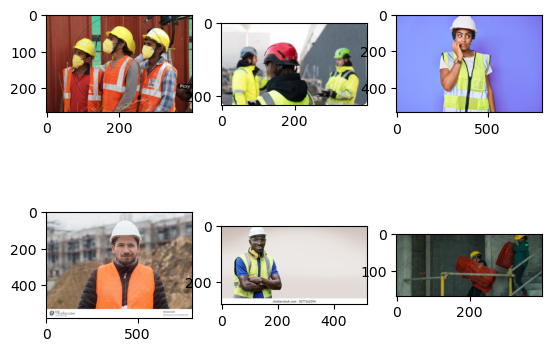

In [3]:
# Visualize 6 random samples from each class
no_gear_samples = [f'GearedorNot\\Not Wearing Safety Gear\\{pic}' for pic in sample(listdir("GearedorNot\\Not Wearing Safety Gear"),6)]
gear_samles = [f'GearedorNot\\Wearing Safety Gear\\{pic}' for pic in sample(listdir("GearedorNot\\Wearing Safety Gear"),6)]
images = imread_collection(no_gear_samples)
imshow_collection(images)
print('6 random images from "Not Wearing Safety Gear" class')
show()
print(f'{"-"*100}')
print('6 random images from "Wearing Safety Gear" class')
images = imread_collection(gear_samles)
imshow_collection(images)
show()

In [21]:
def Make_dirs(main_path) -> tuple:
    ''' 
    Creates a directory structure for training, validation, and test datasets.

    Parameters:
    main_path (str): The main directory path where the 'ready_for_generating' folder will be created.

    Yields:
    str: Path to the created subdirectories (train, validation, test).
    '''
    
    # Remove the 'ready_for_generating' directory if it already exists
    if 'ready_for_generating' in listdir(main_path): 
        rmtree(f'{main_path}\\ready_for_generating')

    # Create the 'ready_for_generating' directory
    mkdir(f'{main_path}\\ready_for_generating')
    
    # Create subdirectories for 'train', 'validation', and 'test'
    for i in ['train', 'validation', 'test']:
        mkdir(f'{main_path}\\ready_for_generating\\{i}')
        mkdir(f'{main_path}\\ready_for_generating\\{i}\\Not Wearing Safety Gear')
        mkdir(f'{main_path}\\ready_for_generating\\{i}\\Wearing Safety Gear')
        
        # Yield the path to each subdirectory
        yield f'{main_path}\\ready_for_generating\\{i}'

In [22]:
# Preparing paths for train, validation and test sets
train_path , val_path , test_path = Make_dirs('D:\\datasets\\Gear')

In [23]:
def Split_data(classes, train_siz=0.8) -> None:
    ''' 
    Splits data into training, validation, and test sets and copies files to the respective directories.

    Parameters:
    classes (list): List of class names (e.g., ['Wearing Safety Gear', 'Not Wearing Safety Gear']).
    train_siz (float, optional): Proportion of data to be used for training. Default is 0.8.

    Returns:
    None
    '''
    
    for i in classes:
        seed(123)  # Set seed for reproducibility
        
        # Calculate the number of training samples
        size = ((train_siz*100) * len(listdir(f'D:\\datasets\\Gear\\GearedorNot\\{i}'))) // 100
        
        # Randomly sample training images
        train_pics = sample(listdir(f'D:\\datasets\\Gear\\GearedorNot\\{i}'), int(size))
        
        # Get remaining images and randomly split them into validation set
        x = [j for j in listdir(f'D:\\datasets\\Gear\\GearedorNot\\{i}') if j not in train_pics]
        val_pics = sample(x, len(x) // 2)
        
        for pic in listdir(f'D:\\datasets\\Gear\\GearedorNot\\{i}'):
            try:
                # Read the image to ensure it is not corrupted
                test = imread(f'D:\\datasets\\Gear\\GearedorNot\\{i}\\{pic}')
                
                # Copy the image to the respective directory
                if pic in train_pics:
                    copyfile(f'D:\\datasets\\Gear\\GearedorNot\\{i}\\{pic}', f'{train_path}\\{i}\\{pic}')
                elif pic in val_pics:
                    copyfile(f'D:\\datasets\\Gear\\GearedorNot\\{i}\\{pic}', f'{val_path}\\{i}\\{pic}')
                else:
                    copyfile(f'D:\\datasets\\Gear\\GearedorNot\\{i}\\{pic}', f'{test_path}\\{i}\\{pic}')
            except:
                # Handle the case where the image is corrupted or unreadable
                print(f'Zero image, So ignoring!. ({pic})')

In [24]:
# Splitting photos to train, validation and test sets.
# 80% of data is considered as train set 10% for validation and 10% for test
Split_data(listdir('D:\\datasets\\Gear\\GearedorNot'))

In [25]:
# Generating photos
ready_train = gen.flow_from_directory(train_path,
                                      target_size=(150,150), # Resize photos
                                      class_mode='binary',
                                      batch_size=5)

ready_val = gen.flow_from_directory(val_path,
                                      target_size=(150,150),
                                      class_mode='binary',
                                      batch_size=3)

ready_test = gen.flow_from_directory(test_path,
                                      target_size=(150,150),
                                      class_mode='binary',
                                      batch_size=3)

Found 283 images belonging to 2 classes.
Found 35 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


# Part 2

### Modeling and evaluating

In [26]:
# Load the pre-trained InceptionV3 model with the top layers excluded
pre_trained_model = InceptionV3(include_top=False, input_shape=(150,150,3))

# Freeze all layers in the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

# Get the output of the 'mixed5' layer
last_layer = pre_trained_model.get_layer('mixed5')
out = last_layer.output

# Add a Flatten layer followed by a Dense layer with a sigmoid activation
l1 = Flatten()(out)
l2 = Dense(1, activation='sigmoid')(l1)

# Define the new model
model = Model(pre_trained_model.input, l2)

# Compile the model with 'rmsprop' optimizer and binary crossentropy loss
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_188 (Conv2D)           │ (None, 74, 74, 32)        │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_188       │ (None, 74, 74, 32)        │              96 │ conv2d_188[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_188 (Activation)   │ (None, 74, 74, 32)        │               0 │ batch_normalization_188[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_189 (Conv2D)           │ (None, 72, 72, 32)        │           9,216 │ activation_188[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_189       │ (None, 72, 72, 32)        │              96 │ conv2d_189[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_189 (Activation)   │ (None, 72, 72, 32)        │               0 │ batch_normalization_189[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_190 (Conv2D)           │ (None, 72, 72, 64)        │          18,432 │ activation_189[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_190       │ (None, 72, 72, 64)        │             192 │ conv2d_190[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_190 (Activation)   │ (None, 72, 72, 64)        │               0 │ batch_normalization_190[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 35, 35, 64)        │               0 │ activation_190[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_191 (Conv2D)           │ (None, 35, 35, 80)        │           5,120 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_191       │ (None, 35, 35, 80)        │             240 │ conv2d_191[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_191 (Activation)   │ (None, 35, 35, 80)        │               0 │ batch_normalization_191[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_192 (Conv2D)           │ (None, 33, 33, 192)       │         138,24

 Total params: 5,176,289 (19.75 MB)

 Trainable params: 37,633 (147.00 KB)

 Non-trainable params: 5,138,656 (19.60 MB)

In [28]:
history = model.fit(ready_train,epochs=10,validation_data = ready_val)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 376ms/step - accuracy: 0.6925 - loss: 1.8051 - val_accuracy: 0.8571 - val_loss: 0.3305
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - accuracy: 0.9735 - loss: 0.0980 - val_accuracy: 0.9714 - val_loss: 0.1046
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step - accuracy: 0.9974 - loss: 0.0092 - val_accuracy: 0.9714 - val_loss: 0.1345
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 1.0000 - loss: 3.7658e-04 - val_accuracy: 0.9714 - val_loss: 0.0885
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - accuracy: 1.0000 - loss: 1.0131e-04 - val_accuracy: 0.9714 - val_loss: 0.1141
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.9969 - loss: 0.0045 - val_accuracy: 0.9714 - val_loss: 0.1043
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 1.0000 - loss: 2.8078e-05 - val_accuracy: 0.9714 - val_loss: 0.0820
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 9.9183

In [29]:
res_test = model.evaluate(ready_test)
print(f'Accuracy on test set: {res_test[1]*100:0.1f}%\nLoss on test set: {res_test[0]:0.3f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9449 - loss: 0.2653
Accuracy on test set: 94.6%
Loss on test set: 0.381


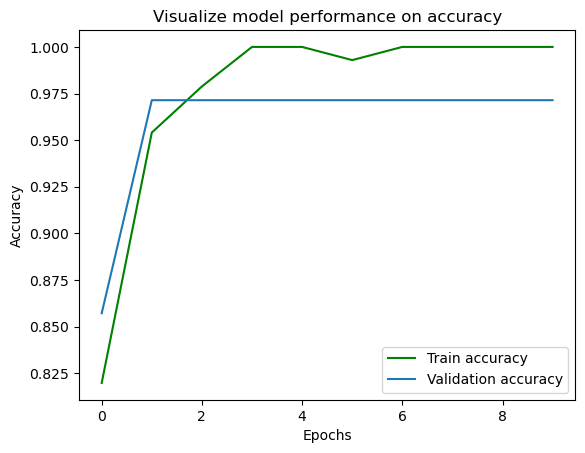

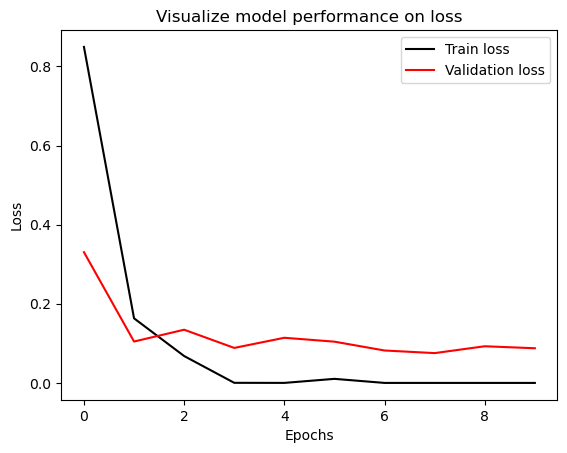

In [30]:
Epochs = len(history.epoch)
plot(history.epoch,history.history['accuracy'],'green')
plot(history.epoch,history.history['val_accuracy'])
xlabel('Epochs')
ylabel('Accuracy')
title('Visualize model performance on accuracy')
legend(['Train accuracy','Validation accuracy'])
show()
plot(history.epoch,history.history['loss'],'black')
plot(history.epoch,history.history['val_loss'],'red')
xlabel('Epochs')
ylabel('Loss')
title('Visualize model performance on loss')
legend(['Train loss','Validation loss'])
show()

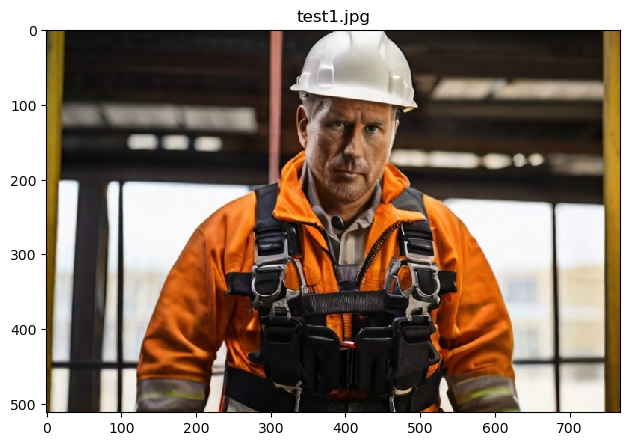

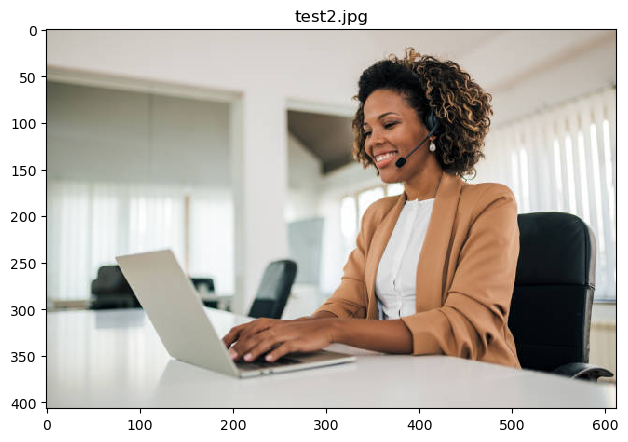

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label for test1.jpg: Wearing Safety Gear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted label for test2.jpg: Not Wearing Safety Gear


In [31]:
# Evaluating model's performance on two random images from internet
for t in ['test1.jpg','test2.jpg']:
    pic = imread(t)
    imshow(pic)
    title(t)
    show()
    
for test in ['test1.jpg','test2.jpg']:
    x = load_img(test,target_size=(150,150))
    xarr = img_to_array(x)/255
    xarr = expand_dims(xarr,axis=0)
    pred = model.predict(xarr)
    lbl = None
    if pred[0][0]>=0.5: lbl = 'Wearing Safety Gear'
    else : lbl = 'Not Wearing Safety Gear'
    print(f'Predicted label for {test}: {lbl}')

# End